In [2]:
from APP.data.data_generation import generate_fake_dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from APP.sources.evaluation import *

In [3]:
# generate fake data
datasets_df, data_df = generate_fake_dataset(20000)

print(datasets_df.head())
print(data_df.head())

   org_id    id                   name  type
0       1  ds_1              Short PLC  text
1       2  ds_2               Gray Inc  text
2       3  ds_3               Roth Ltd  text
3       4  ds_4           Wilson Group  text
4       5  ds_5  Lee, Olson and Obrien  text
  dataset_id      id                                              value   flag
0       ds_1  item_1  Doctor receive I everybody though fish. Day le...  False
1       ds_1  item_2  Trial Mrs say wide no year. News land seat sol...  False
2       ds_1  item_3  Federal hard throw perform. Else suggest somet...  False
3       ds_1  item_4  Hard prevent through case agreement water. gre...   True
4       ds_1  item_5  Many fine performance five add director as bot...   True


In [8]:
# split data into train and test
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

print(f"Train data size: {len(train_df)}")
print(f"Test data size: {len(test_df)}")


Train data size: 16000
Test data size: 4000


## Train PII Detector Model

In [4]:
from transformers import BertTokenizer

/Users/xinzhang/.pyenv/versions/realtime_interview_copilot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from APP.sources.PIIDetector_rf import PIIDetector
from APP.data.data_class import Data

In [6]:
detector = PIIDetector()
detector.train(train_df)

Training with DataFrame containing 16000 rows
DataFrame columns: ['dataset_id', 'id', 'value', 'flag']
First row sample: {'dataset_id': 'ds_2', 'id': 'item_1895', 'value': 'Reach worry put fall newspaper when. Sister boy member politics claim.', 'flag': False}
Extracted 16000 texts and 16000 labels
Converting 16000 texts to feature vectors
Split data into 12800 training and 3200 testing samples
Model training completed

Model Evaluation:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2183
           1       0.98      0.82      0.90      1017

    accuracy                           0.94      3200
   macro avg       0.95      0.91      0.93      3200
weighted avg       0.94      0.94      0.94      3200

Confusion Matrix:
[[2166   17]
 [ 178  839]]


In [25]:
import os
import pickle
model_path = 'pii_detector_model_rf.pkl'
directory = os.path.dirname(model_path)
    
    # 只有当目录名不为空时才创建目录
if directory:
    os.makedirs(directory, exist_ok=True)

# 保存整个对象
with open(model_path, 'wb') as f:
    pickle.dump(detector, f)

In [7]:
test_text = "My name is John Smith and I live at 123 Main Street, New York. You can contact me at john.smith@example.com or call me at (555) 123-4567."
result = detector.predict(test_text)

print("\nPII Detection Result:")
print(f"Has PII: {result['has_pii']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"PII Types: {', '.join(result['pii_types'])}")
print("Details:")
for pii_type, instances in result['details'].items():
    print(f"  {pii_type}: {instances}")


PII Detection Result:
Has PII: True
Confidence: 0.9900
PII Types: email, phone, address, person, gpe
Details:
  email: ['john.smith@example.com']
  phone: ['']
  address: ['123 Main Street']
  person: ['John Smith']
  gpe: ['New York']


# Train Bert Model

In [8]:
from App.sources.PIIDetector_bert import preprocess_data
from transformers import BertForSequenceClassification, TrainingArguments, Trainer


In [9]:
# Initialize model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Create trainer
train_dataset, test_dataset = preprocess_data(train_df)
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/xinzhang/.pyenv/versions/realtime_interview_copilot/lib/python3.9/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Map: 100%|██████████| 3200/3200 [00:00<00:00, 4007.68 examples/s]


Epoch,Training Loss,Validation Loss
1,0.029600,0.000039
2,0.000800,0.000017
3,0.000000,0.000013


TrainOutput(global_step=2400, training_loss=0.006643229554174468, metrics={'train_runtime': 1384.01, 'train_samples_per_second': 27.745, 'train_steps_per_second': 1.734, 'total_flos': 2525866131456000.0, 'train_loss': 0.006643229554174468, 'epoch': 3.0})

In [13]:
# Save model

model_path = "Trained_models/pii_detector_model_bert"
trainer.save_model(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.save_pretrained(model_path)

('./pii_detector_model_bert/tokenizer_config.json',
 './pii_detector_model_bert/special_tokens_map.json',
 './pii_detector_model_bert/vocab.txt',
 './pii_detector_model_bert/added_tokens.json')

## Evaluate Models

In [11]:
# load rf model
import pickle
with open('pii_detector_model_rf.pkl', 'rb') as f:
    detector = pickle.load(f)

# load bert model
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments

bert_model_path = "pii_detector_model_bert"
bert_model = BertForSequenceClassification.from_pretrained(bert_model_path, num_labels=2)
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_path)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    disable_tqdm=True,
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args,
)

In [12]:
evaluation_results = evaluate_models(test_df, detector, trainer_bert, bert_tokenizer)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Inference Time (s)'],
    'Random Forest': [
        evaluation_results['random_forest']['accuracy'],
        evaluation_results['random_forest']['precision'],
        evaluation_results['random_forest']['recall'],
        evaluation_results['random_forest']['f1'],
        evaluation_results['random_forest']['auc'],
        evaluation_results['random_forest']['inference_time']
    ],
    'BERT': [
        evaluation_results['bert']['accuracy'],
        evaluation_results['bert']['precision'],
        evaluation_results['bert']['recall'],
        evaluation_results['bert']['f1'],
        evaluation_results['bert']['auc'],
        evaluation_results['bert']['inference_time']
    ]
})

print(comparison_df)

               Metric  Random Forest       BERT
0            Accuracy       0.943000   1.000000
1           Precision       0.873503   1.000000
2              Recall       0.951876   1.000000
3            F1 Score       0.911007   1.000000
4                 AUC       0.985578   1.000000
5  Inference Time (s)      32.590107  29.393385


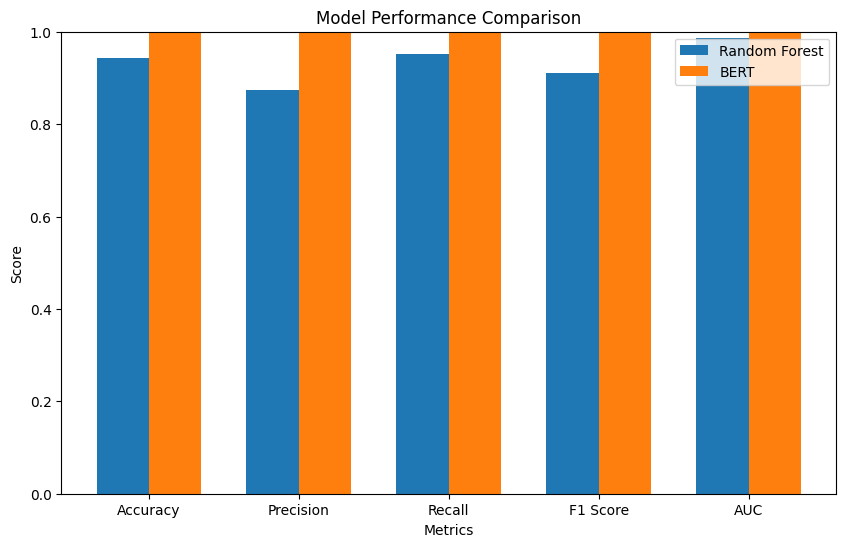

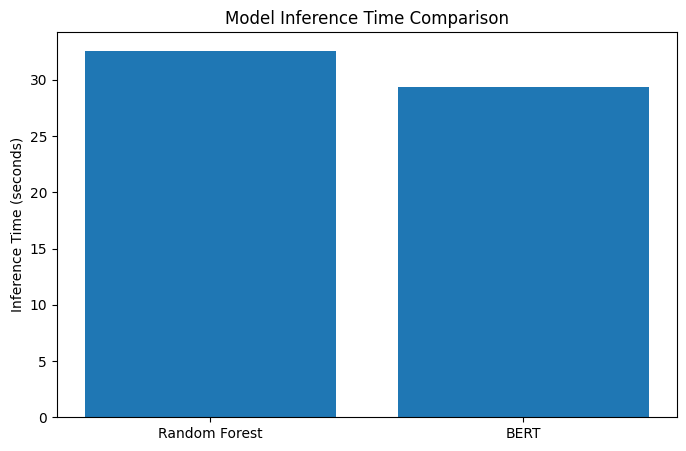

In [14]:
import matplotlib.pyplot as plt
import numpy as np

metrics = comparison_df['Metric'][:5] 
rf_scores = comparison_df['Random Forest'][:5]
bert_scores = comparison_df['BERT'][:5]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, rf_scores, width, label='Random Forest')
plt.bar(x + width/2, bert_scores, width, label='BERT')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.show()


plt.figure(figsize=(8, 5))
times = [evaluation_results['random_forest']['inference_time'], 
         evaluation_results['bert']['inference_time']]
plt.bar(['Random Forest', 'BERT'], times)
plt.ylabel('Inference Time (seconds)')
plt.title('Model Inference Time Comparison')

plt.show()

In [ ]:
analyze_case_differences(test_df, detector, trainer_bert, bert_tokenizer)